# **AlexNet(2012) code 구현**


모델 아키텍처

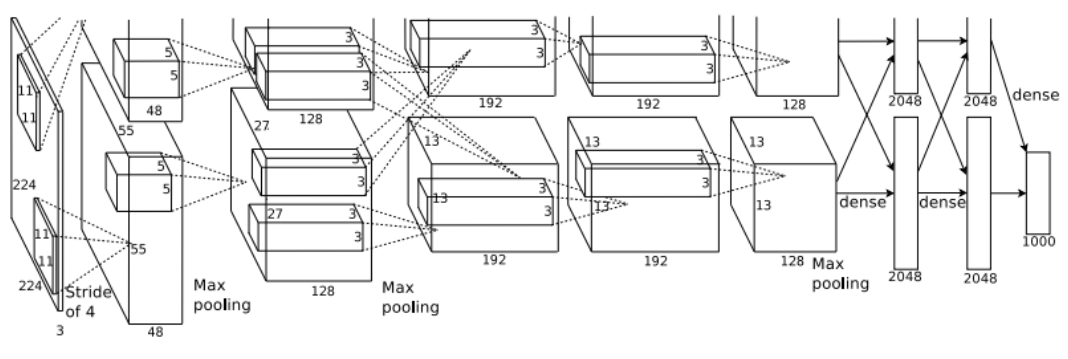

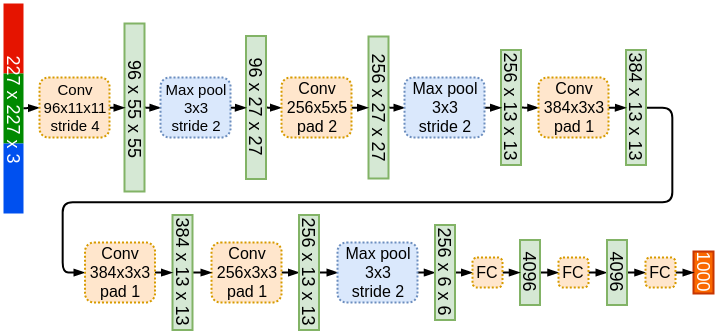

# PyTorch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device   # cuda 지정

device(type='cuda')

In [ ]:
# 논문 5. Details of learning 참고 parameter
batch_size = 128
momentum = 0.9
lr_decay = 0.0005
lr_init = 0.01
image_dim = 227    # pixels
num_classes = 1000   # 1000개의 class 지정
device_ids = [0, 1, 2, 3]

In [ ]:
class AlexNet(nn.Module):

  def __init__(self, num_classes=1000):
    super().__init__()

    ##### CNN layers 
    self.net = nn.Sequential(
        # conv1
        nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4),
        nn.ReLU(inplace=True),  # non-saturating function
        nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),  # 논문의 LRN 파라미터 그대로 지정
        nn.MaxPool2d(kernel_size=3, stride=2),
        # conv2
        nn.Conv2d(96, 256, kernel_size=5, padding=2), 
        nn.ReLU(inplace=True),
        nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
        nn.MaxPool2d(kernel_size=3, stride=2),
        # conv3
        nn.Conv2d(256, 384, 3, padding=1),
        nn.ReLU(inplace=True),
        # conv4
        nn.Conv2d(384, 384, 3, padding=1),
        nn.ReLU(inplace=True),
        # conv5
        nn.Conv2d(384, 256, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),

    )

    ##### FC layers
    self.classifier = nn.Sequential(
        # fc1
        nn.Dropout(p=0.5, inplace=True),
        nn.Linear(in_features=(256 * 6 * 6), out_features=4096),
        nn.ReLU(inplace=True).
        # fc2
        nn.Dropout(p=0.5, inplace=True),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Linear(4096, num_classes),
    )

    # bias, weight 초기화 
    def init_bias_weights(self):
      for layer in self.net:
        if isinstance(layer, nn.Conv2d):
          nn.init.normal_(layer.weight, mean=0, std=0.01)   # weight 초기화
          nn.init.constant_(layer.bias, 0)   # bias 초기화

      # conv 2, 4, 5는 bias 1로 초기화 
      nn.init.constant_(self.net[4].bias, 1)
      nn.init.constant_(self.net[10].bias, 1)
      nn.init.constant_(self.net[12].bias, 1)

    # modeling 
    def forward(self, x):
      x = self.net(x)   # conv
      x = x.view(-1, 256*6*6)   # keras의 reshape (텐서 크기 2d 변경)
      return self.classifier(x)   # fc   

In [ ]:
if __name__== '__main__':
  seed = torch.initial_seed()  # seed value 설정
  model = AlexNet(num_classes=num_classes).to(device)
  model = torch.nn.parallel.DataParallel(model, divice_ids=device_ids)  # 모델 설정
  print(model)

  # dataset, data loader 설정
  dataset = datasets.ImageFolder(TRAIN_IMG_DIR, transforms.Compose([
      transforms.CenterCrop(IMAGE_DIM),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ]))

  dataloader = data.DataLoader(
      dataset,
      shuffle=True,
      pin_memory=True,
      num_workers=8,
      drop_last=True,
      batch_size=batch_size)

  # optimizer
  optimizer = optim.SGD(
      params = model.parameters(),
      lr = lr_init,
      momentum = momentum,
      weight_decay = lr_decay  # lr 점점 감소
  )

  lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)   # lr 점점 감소

  # training
  total_steps=1
  for epoch in range(num_epochs):
    lr_scheduler.step()

    for imgs, classes in dataloader:
      imgs, classes = imgs.to(device), classes.to(device)

      output = alexnet(imgs)
      loss = F.cross_entropy(output, classes)  # loss 계산

      optimizer.zero_grad()
      loss.backward()  # backpropa
      optimizer.step()  # parameter update

# Keras

In [1]:
pip install tensorboardcolab   # tensorboard 설치

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for tensorboardcolab: filename=tensorboardcolab-0.0.22-py3-none-any.whl size=3859 sha256=114c33ba00f9e0784d48c642d33322b020153cbec37bd626a2eb3c9b667ae2cc
  Stored in directory: /root/.cache/pip/wheels/69/4e/4a/1c6c267395cb10edded1050df12af165d3254cfce324e80941
Successfully built tensorboardcolab


In [2]:
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback, TensorBoard
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from sklearn.preprocessing import LabelBinarizer
from tensorflow.nn import local_response_normalization  # lrn

In [3]:
# modeling(functional API)
input_shape = (224, 224, 3)  # 논문에서 제시된 shape
x = Input(shape = input_shape, name='INPUT')

# CONV
conv1 = Conv2D(filters=96, kernel_size=11, activation='relu', strides=4, name='CONV_1')(x)
pool1 = MaxPooling2D((3,3), strides=2, name='POOL_1')(conv1)  # overlapped pooling
# lrn1 = local_response_normalization(conv1,depth_radius=5, bias=2, alpha=0.0001, beta=0.75) 
lrn1 = BatchNormalization(name='LRN_1')(pool1)

conv2 = Conv2D(filters=256, kernel_size=5, activation='relu', strides=1, padding='same', name='CONV_2')(lrn1)
pool2 = MaxPooling2D((3,3), strides=2, name='POOL_2')(conv2)
# lrn2 = local_response_normalization(conv2,depth_radius=5, bias=2,  alpha=0.0001, beta=0.75)
lrn2 = BatchNormalization(name='LRN_2')(pool2)

conv3 = Conv2D(filters=384, kernel_size=3, activation='relu', strides=1, padding='same', name='CONV_3')(lrn2)
conv4 = Conv2D(filters=384, kernel_size=3, activation='relu', strides=1, padding='same', name='CONV_4')(conv3)
conv5 = Conv2D(filters=256, kernel_size=3, activation='relu', strides=1, padding='same', name='CONV_5')(conv4)
pool3 = MaxPooling2D((3,3), strides=2, name='POOL_3')(conv5)

# FC
f = Flatten()(pool3)
f = Dense(4096, activation='relu', name='FC_1')(f)
f = Dropout(0.5)(f)  # 논문 parameter 0.5 이용
f = Dense(4096, activation='relu', name='FC_2')(f)
f = Dropout(0.5)(f)
out = Dense(1000, activation='softmax', name='OUTPUT')(f)

model = Model(inputs=x, outputs=out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 CONV_1 (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 POOL_1 (MaxPooling2D)       (None, 26, 26, 96)        0         
                                                                 
 LRN_1 (BatchNormalization)  (None, 26, 26, 96)        384       
                                                                 
 CONV_2 (Conv2D)             (None, 26, 26, 256)       614656    
                                                                 
 POOL_2 (MaxPooling2D)       (None, 12, 12, 256)       0         
                                                                 
 LRN_2 (BatchNormalization)  (None, 12, 12, 256)       1024  

# CIFAR10 data 적용

In [4]:
# cifar10 data load
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

170498071/170498071 [==============================] - 14s 0us/step


In [5]:
x_train.shape

(50000, 32, 32, 3)

In [6]:
print(img_height, img_width)   # 224*224 가 아닌 32*32임

32 32


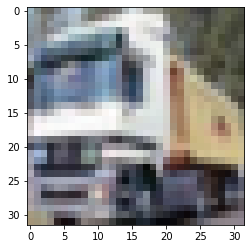

In [7]:
plt.imshow(x_train[1])   # 10개의 물체가 있는 data

In [8]:
batch_size = 128
num_classes = 10
epochs = 10

y_train = to_categorical(y_train, num_classes)  # category화 
y_test = to_categorical(y_test, num_classes)

model = Sequential()
# model.add(Conv2D(96, (11,11), strides=(4,4), activation='relu', padding='same', input_shape=(img_height, img_width, channel,)))
# for original Alexnet
model.add(Conv2D(48, (3,3), strides=(2,2), activation='relu', padding='same', input_shape=(img_height, img_width, channel,)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
# Local Response normalization for Original Alexnet
model.add(BatchNormalization())

model.add(Conv2D(96, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
# Local Response normalization for Original Alexnet
model.add(BatchNormalization())

model.add(Conv2D(192, (3,3), activation='relu', padding='same'))
model.add(Conv2D(192, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
# Local Response normalization for Original Alexnet
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))


In [9]:
y_train.shape

(50000, 10)

In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=10, 
                    verbose=1,
                    validation_data=(x_test, y_test))

Epoch 1/10
391/391 [==============================] - 4s 8ms/step - loss: 0.1191 - accuracy: 0.9614 - val_loss: 1.4684 - val_accuracy: 0.7043
Epoch 2/10
391/391 [==============================] - 3s 7ms/step - loss: 0.1102 - accuracy: 0.9652 - val_loss: 1.3158 - val_accuracy: 0.7293
Epoch 3/10
391/391 [==============================] - 3s 7ms/step - loss: 0.1068 - accuracy: 0.9663 - val_loss: 1.6419 - val_accuracy: 0.6689
Epoch 4/10
391/391 [==============================] - 3s 7ms/step - loss: 0.0895 - accuracy: 0.9707 - val_loss: 1.5072 - val_accuracy: 0.7078
Epoch 5/10
391/391 [==============================] - 3s 7ms/step - loss: 0.0901 - accuracy: 0.9713 - val_loss: 1.3922 - val_accuracy: 0.7247
Epoch 6/10
391/391 [==============================] - 3s 7ms/step - loss: 0.0860 - accuracy: 0.9727 - val_loss: 1.3759 - val_accuracy: 0.7329
Epoch 7/10
391/391 [==============================] - 3s 7ms/step - loss: 0.0852 - accuracy: 0.9729 - val_loss: 1.4296 - val_accuracy: 0.7139
Epoch 

In [13]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
predictions = model.predict(x_test, verbose=1)

313/313 [==============================] - 1s 3ms/step - loss: 1.3677 - accuracy: 0.7312
Test loss: 1.36768639087677
Test accuracy: 0.7311999797821045
313/313 [==============================] - 1s 2ms/step


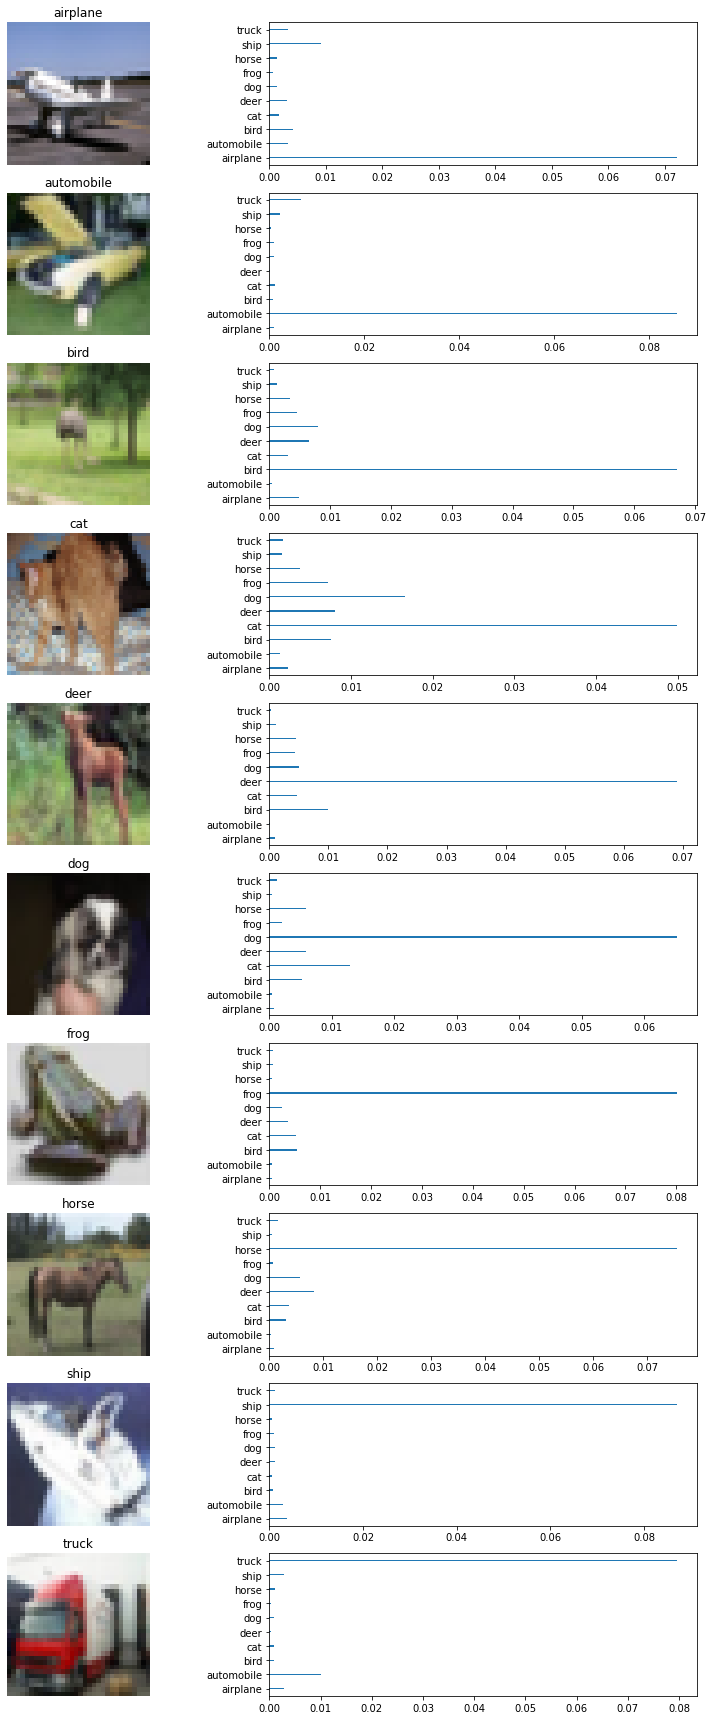

In [14]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_names = load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axs = plt.subplots(10, 2, figsize=(12,24))
    margin = 0.05
    ind = np.arange(n_classes)
    width = (1. - 2. * margin) / n_classes    
    arr_features = [None]*10
    arr_predictions = np.zeros((10, 10))
    last_image_i = 0
    
    for i, prediction in enumerate(predictions):
        label_id = label_ids[i]
        feature = features[i]
        arr_features[label_id] = feature
        max_id = np.argmax(prediction)
        arr_predictions[label_id][max_id] += 1
        last_image_i = i

    arr_predictions /= last_image_i
    
    for i in range(10):
      feature = arr_features[i]
      pred_name = label_names[i]
      prediction = arr_predictions[i]
      axs[i][0].imshow(feature)
      axs[i][0].set_title(pred_name)
      axs[i][0].set_axis_off()

      axs[i][1].barh(ind + margin, prediction, width)
      axs[i][1].set_yticks(ind + margin)
      axs[i][1].set_yticklabels(label_names)

    plt.tight_layout()

display_image_predictions(x_test, y_test, predictions)